In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def validate_data(df):
    print("Dataset shape:", df.shape)
    print("\nMissing values:")
    print(df.isnull().sum())


df = pd.read_csv('data.csv')
validate_data(df)


Dataset shape: (10000, 8)

Missing values:
productId    0
Title        5
userId       0
Time         0
Text         0
Cat1         0
Cat2         0
Cat3         0
dtype: int64


In [5]:
# Dropping the values which have a null Title and save the file for training
df = df.dropna()
validate_data(df)
df.to_csv("data.csv")

Dataset shape: (9995, 8)

Missing values:
productId    0
Title        0
userId       0
Time         0
Text         0
Cat1         0
Cat2         0
Cat3         0
dtype: int64


In [6]:
"""Analyze distribution of categories at each level with detailed statistics"""
print("\n=== Category Distribution Analysis ===\n")

# Calculate value counts for each level
counts = {
    'Cat1': df['Cat1'].value_counts(),
    'Cat2': df['Cat2'].value_counts(),
    'Cat3': df['Cat3'].value_counts()
}

for level in ['Cat1', 'Cat2', 'Cat3']:
    print(f"\n{level} Analysis:")
    print("-" * 50)

    # Count unique categories
    unique_count = len(counts[level])
    print(f"Total unique categories: {unique_count}")

    # Show top categories with percentages
    total_records = len(df)
    print("\nTop 5 categories by frequency:")
    for cat, count in counts[level].head().items():
        percentage = (count / total_records) * 100
        print(f"{cat}: {count} ({percentage:.2f}%)")


=== Category Distribution Analysis ===


Cat1 Analysis:
--------------------------------------------------
Total unique categories: 6

Top 5 categories by frequency:
health personal care: 2987 (29.88%)
beauty: 2135 (21.36%)
toys games: 1759 (17.60%)
pet supplies: 1576 (15.77%)
grocery gourmet food: 840 (8.40%)

Cat2 Analysis:
--------------------------------------------------
Total unique categories: 64

Top 5 categories by frequency:
nutrition wellness: 904 (9.04%)
dogs: 875 (8.75%)
health care: 647 (6.47%)
hair care: 542 (5.42%)
personal care: 528 (5.28%)

Cat3 Analysis:
--------------------------------------------------
Total unique categories: 377

Top 5 categories by frequency:
vitamins supplements: 665 (6.65%)
unknown: 487 (4.87%)
women s: 286 (2.86%)
shaving hair removal: 280 (2.80%)
face: 262 (2.62%)


In [7]:
"""Analyze transitions between hierarchical levels with detailed printing"""
print("\n=== Hierarchical Transition Analysis ===\n")

transitions = defaultdict(dict)

# Analyze Cat1 to Cat2 transitions
print("Cat1 → Cat2 Transitions:")
print("-" * 50)
for cat1 in df['Cat1'].unique():
    cat2_subset = df[df['Cat1'] == cat1]['Cat2'].value_counts()
    transitions['cat1_to_cat2'][cat1] = {
        'total_subcategories': len(cat2_subset),
        'top_subcategories': cat2_subset.head(5).to_dict()
    }
    print(f"\n{cat1}:")
    print(f"Total unique Cat2 categories: {len(cat2_subset)}")
    print("Top 5 Cat2 categories:")
    for cat2, count in cat2_subset.head().items():
        print(f"  - {cat2}: {count}")

# Analyze Cat2 to Cat3 transitions
print("\nCat2 → Cat3 Transitions:")
print("-" * 50)
for cat2 in df['Cat2'].unique():
    cat3_subset = df[df['Cat2'] == cat2]['Cat3'].value_counts()
    transitions['cat2_to_cat3'][cat2] = {
        'total_subcategories': len(cat3_subset),
        'top_subcategories': cat3_subset.head(5).to_dict()
    }
    print(f"\n{cat2}:")
    print(f"Total unique Cat3 categories: {len(cat3_subset)}")
    print("Top 5 Cat3 categories:")
    for cat3, count in cat3_subset.head().items():
        print(f"  - {cat3}: {count}")

# Collect and analyze unique paths
unique_paths = set()
for _, row in df.iterrows():
    unique_paths.add(f"{row['Cat1']}>{row['Cat2']}>{row['Cat3']}")

print(f"\nTotal unique hierarchical paths: {len(unique_paths)}")


=== Hierarchical Transition Analysis ===

Cat1 → Cat2 Transitions:
--------------------------------------------------

pet supplies:
Total unique Cat2 categories: 6
Top 5 Cat2 categories:
  - dogs: 875
  - cats: 476
  - fish aquatic pets: 142
  - birds: 51
  - bunny rabbit central: 21

health personal care:
Total unique Cat2 categories: 7
Top 5 Cat2 categories:
  - nutrition wellness: 904
  - health care: 647
  - personal care: 528
  - medical supplies equipment: 414
  - household supplies: 362

grocery gourmet food:
Total unique Cat2 categories: 16
Top 5 Cat2 categories:
  - pantry staples: 240
  - beverages: 215
  - candy chocolate: 132
  - snack food: 71
  - breakfast foods: 39

toys games:
Total unique Cat2 categories: 17
Top 5 Cat2 categories:
  - games: 222
  - learning education: 161
  - stuffed animals plush: 161
  - baby toddler toys: 139
  - action toy figures: 115

beauty:
Total unique Cat2 categories: 6
Top 5 Cat2 categories:
  - hair care: 542
  - fragrance: 514
  - skin 

In [8]:
"""Analyze patterns over time"""
print("\n=== Temporal Pattern Analysis ===\n")

df['Time'] = pd.to_datetime(df['Time'], unit='s')

# Daily distribution
print("Daily Distribution:")
print("-" * 50)
daily_dist = df.groupby(df['Time'].dt.day_name())['productId'].count()
for day, count in daily_dist.items():
    print(f"{day}: {count}")

# Hourly distribution
print("\nHourly Distribution:")
print("-" * 50)
hourly_dist = df.groupby(df['Time'].dt.hour)['productId'].count()
for hour, count in hourly_dist.items():
    print(f"Hour {hour:02d}:00 - {count}")


=== Temporal Pattern Analysis ===

Daily Distribution:
--------------------------------------------------
Friday: 1414
Monday: 1498
Saturday: 1226
Sunday: 1331
Thursday: 1471
Tuesday: 1501
Wednesday: 1554

Hourly Distribution:
--------------------------------------------------
Hour 00:00 - 9995


We can see that the distribution is mostly uniform in temporal dimension, hence this can be ignored as a feature, and more important features like text should be given preference.

In [9]:
# Creating visualisations for the data to understand the data better

def plot_hierarchical_distributions(df, figsize=(15, 20),
                                 top_n={'Cat1': None, 'Cat2': 20, 'Cat3': 20},
                                 output_path=None):
    """Create sorted histograms for each level of the hierarchical classification"""
    print("\n=== Creating Hierarchical Distribution Plots ===\n")
    
    # Calculate value counts for each level
    counts = {
        'Cat1': df['Cat1'].value_counts(),
        'Cat2': df['Cat2'].value_counts(),
        'Cat3': df['Cat3'].value_counts()
    }
    
    # Create the figure
    fig, axes = plt.subplots(3, 1, figsize=figsize)
    plt.subplots_adjust(hspace=0.4)
    
    # Plot for each level
    for idx, (level) in enumerate(zip(['Cat1', 'Cat2', 'Cat3'])):
        data = counts[level]
        
        # Apply top_n filter if specified
        if top_n[level] is not None:
            data = data.head(top_n[level])
        
        # Create horizontal bar plot
        ax = axes[idx]
        bars = ax.barh(range(len(data)), data.values, alpha=0.8)
        
        # Customize the plot
        ax.set_title(f'Distribution of {level} Categories', pad=20, fontsize=12, fontweight='bold')
        ax.set_xlabel('Count', fontsize=10)
        ax.set_ylabel('Category', fontsize=10)
        
        # Set y-tick labels
        ax.set_yticks(range(len(data)))
        ax.set_yticklabels(data.index, fontsize=8)
        
        # Add count labels on bars
        for i, bar in enumerate(bars):
            width = bar.get_width()
            percentage = (width / len(df)) * 100
            ax.text(width, i, f'  {int(width)} ({percentage:.1f}%)',
                   va='center', fontsize=8)
        
        # Add grid
        ax.grid(True, axis='x', linestyle='--', alpha=0.7)
        
        # Add statistics
        stats_text = (f'Total Categories: {len(counts[level])}\n'
                     f'Most Common: {counts[level].index[0]}\n'
                     f'Top Count: {counts[level].iloc[0]}')
        
        ax.text(1.02, 0.98, stats_text,
               transform=ax.transAxes,
               bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
               verticalalignment='top',
               fontsize=8)
    
    # Add overall title
    fig.suptitle('Hierarchical Category Distribution Analysis',
                 fontsize=14, fontweight='bold', y=0.95)
    
    # Save or show the plot
    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
        plt.close()
    else:
        plt.show()

def create_additional_visualizations(df):
    """Create additional visual analyses of the hierarchy"""
    print("\n=== Creating Additional Visualizations ===\n")
    
    # Category Relationships Heatmap
    plt.figure(figsize=(15, 8))
    pivot_table = pd.crosstab(df['Cat1'], df['Cat2'])
    sns.heatmap(pivot_table, cmap='YlOrRd', cbar_kws={'label': 'Count'})
    plt.title('Relationship between Cat1 and Cat2')
    plt.tight_layout()
    plt.show()


=== Creating Hierarchical Distribution Plots ===



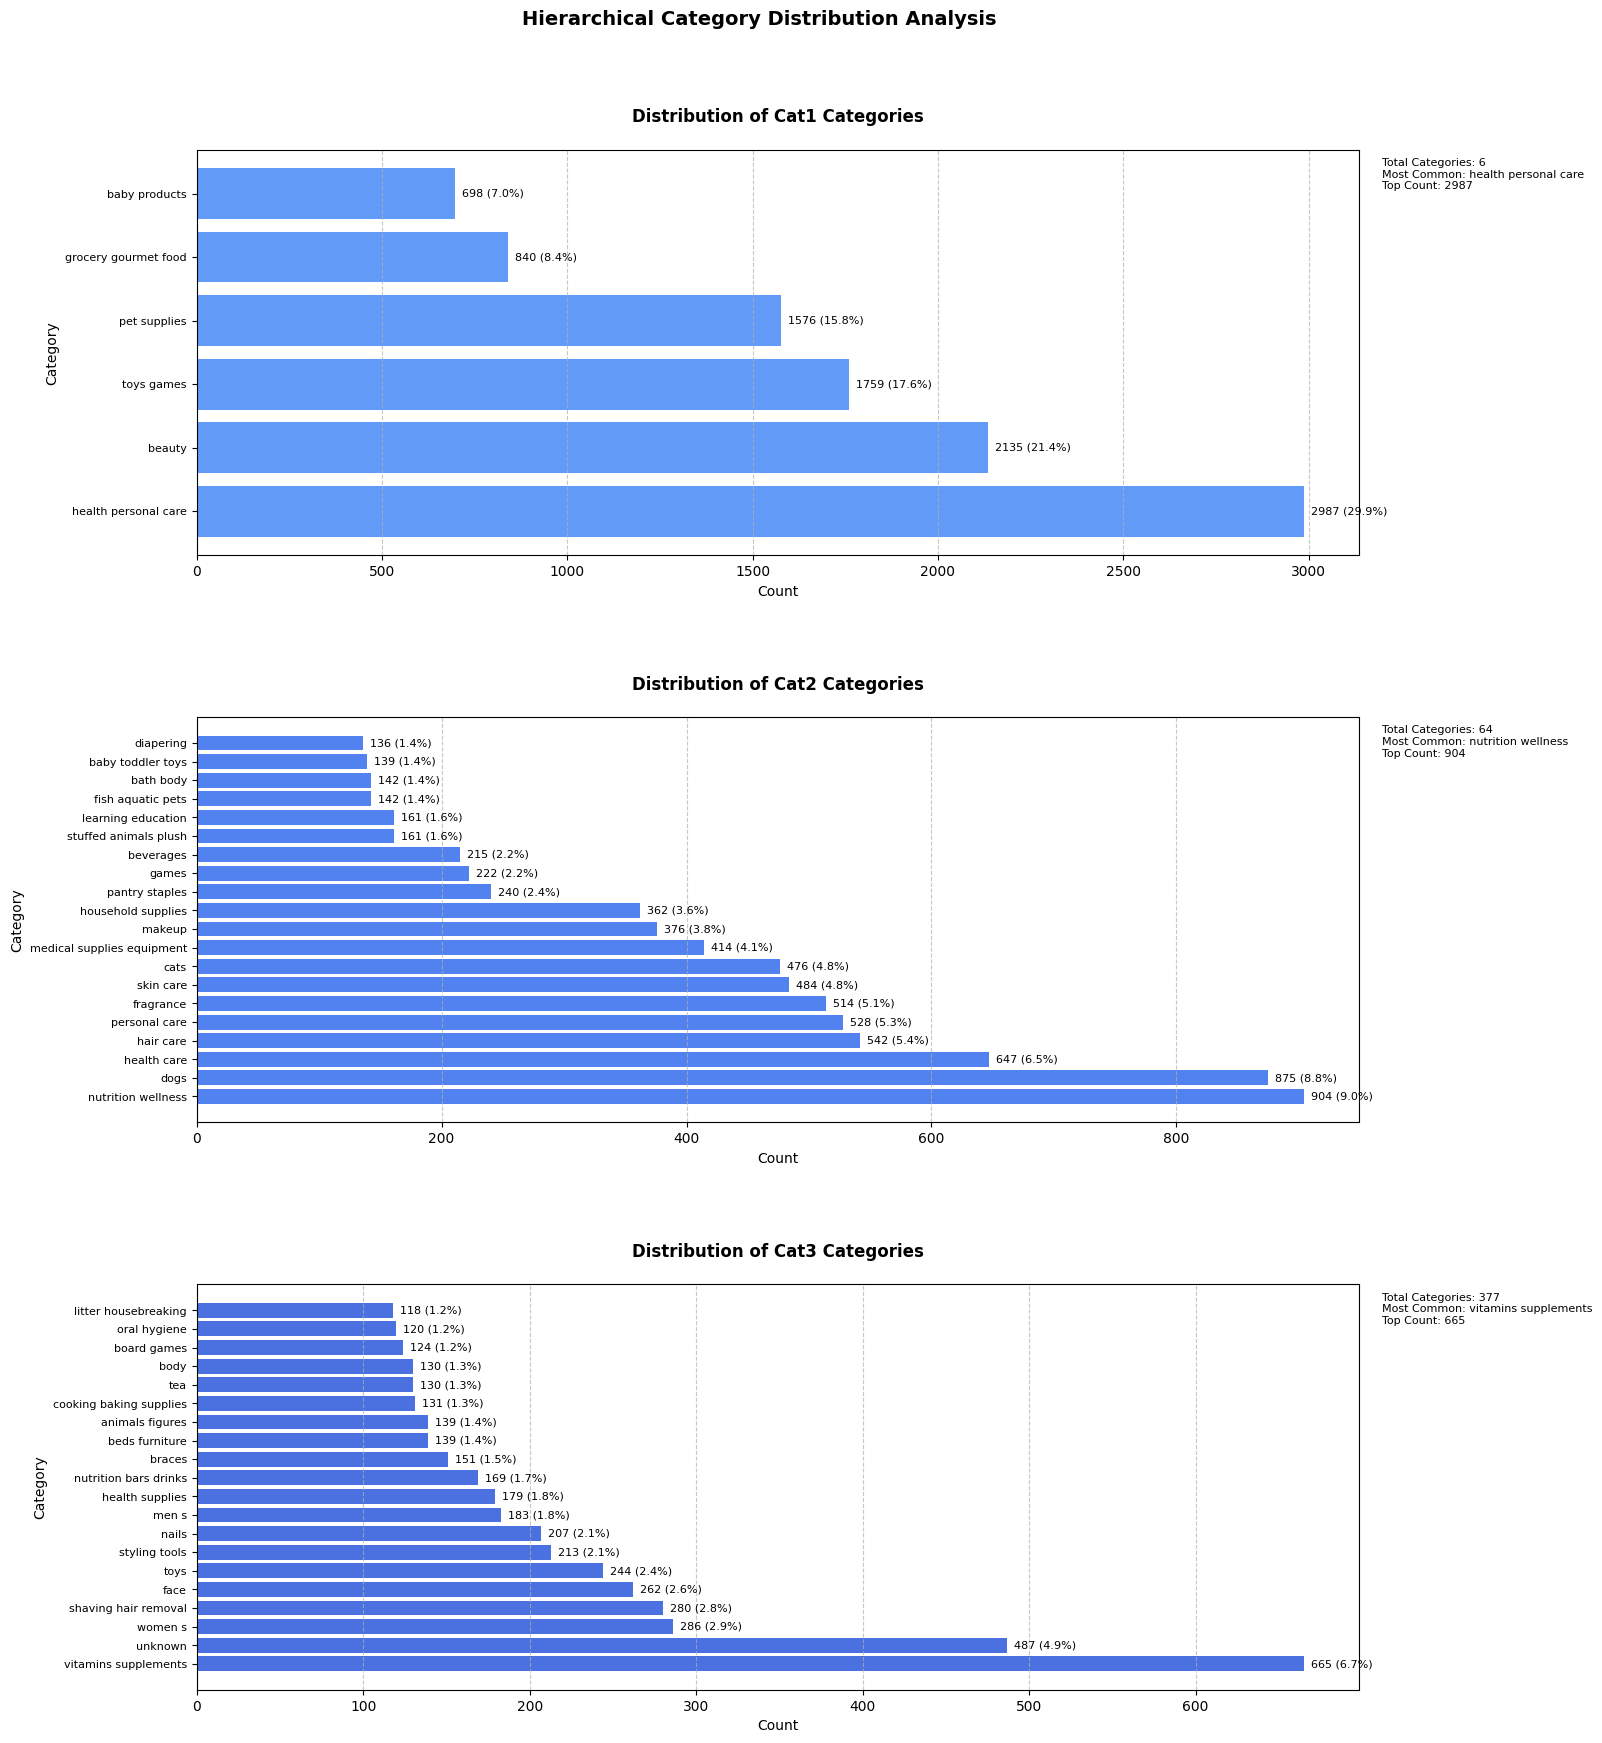

In [10]:
plot_hierarchical_distributions(df)


=== Creating Additional Visualizations ===



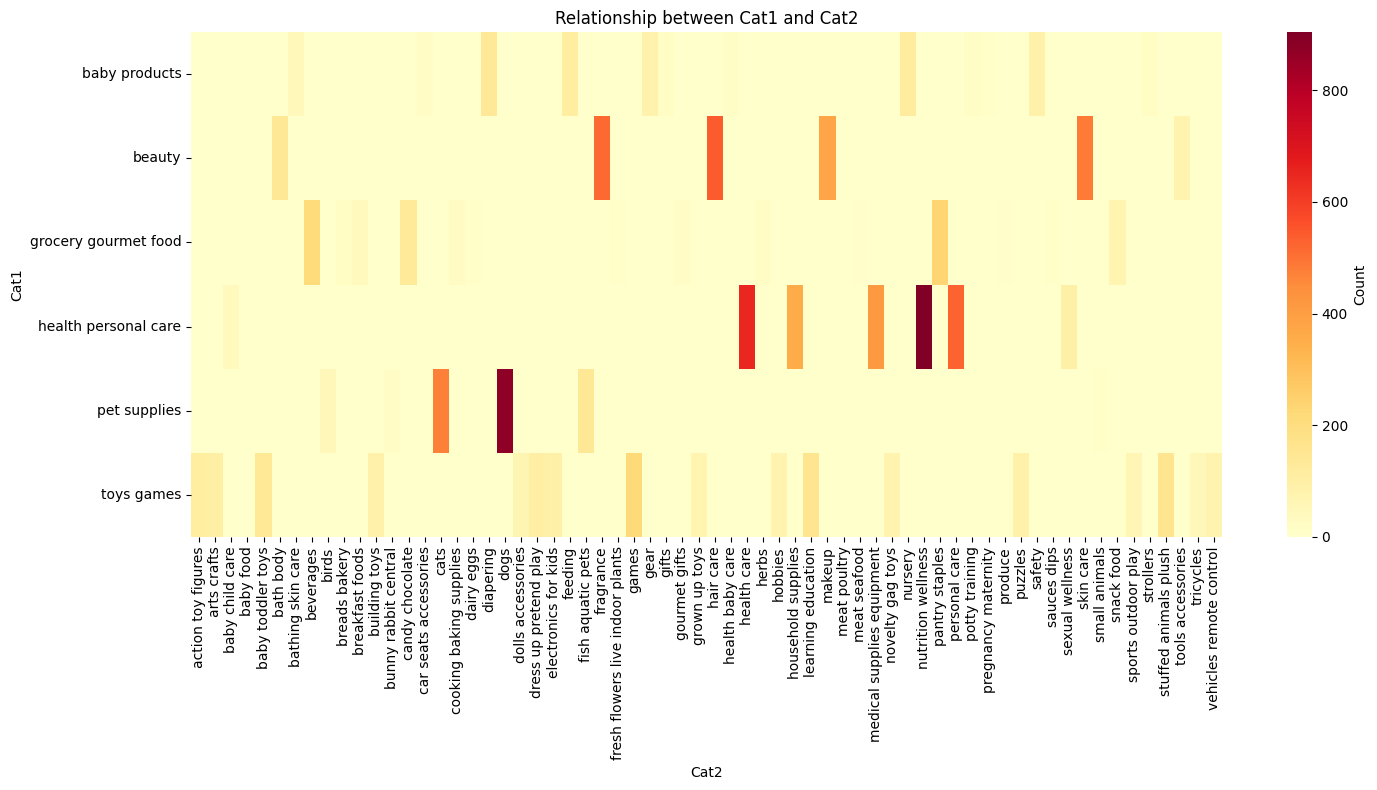

In [11]:
create_additional_visualizations(df)